In [1]:
import OpenBlender
import pandas as pd
import json
import numpy as np
import csv
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold
from time import localtime
from datetime import datetime as dt
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist


In [2]:
def retTStamp(l):
    ret = []
    for i in l:
        date_time_obj = dt.fromtimestamp(i).replace(minute=0,second=0,hour=0)
#         print(date_time_obj)
        ret.append(date_time_obj)
    return ret
def handleNa(num):
    return num if not np.isnan(num) else 0

In [3]:
data     = pd.read_csv('input/coronaUTD.csv')
geo_data = pd.read_csv('popData.csv')
# column headers
# 'confirmed', 'countryregion', 'deaths', 'latitude', 'longitude',
# 'provincestate', 'recovered', 'timestamp'

# fix empty provincestate data and states that are at diff points
# find better solution later if I care
for i,j in data.iterrows():
    if not type(j['provincestate'])==str:
        data.at[i,'provincestate'] = j['countryregion']
    else:
        if(', MA' in j['provincestate']):
            data.at[i,'provincestate'] = 'Massachusetts'
        if(', FL' in j['provincestate']):
            data.at[i,'provincestate'] = 'Florida'
        if(', CA' in j['provincestate']):
            data.at[i,'provincestate'] = 'California'
        if(', TX' in j['provincestate']):
            data.at[i,'provincestate'] = 'Texas'
        if(', NJ' in j['provincestate']):
            data.at[i,'provincestate'] = 'New Jersey'
        if(', CT' in j['provincestate']):
            data.at[i,'provincestate'] = 'Connecticut'
        if(', WA' in j['provincestate']):
            data.at[i,'provincestate'] = 'Washington'
        if(', OR' in j['provincestate']):
            data.at[i,'provincestate'] = 'Oregon'
        if(', D.C.' in j['provincestate']):
            data.at[i,'provincestate'] = 'WaDC'
        if(', LA' in j['provincestate']):
            data.at[i,'provincestate'] = 'Louisiana'
        elif('New York' in j['provincestate']):
            data.at[i,'provincestate'] = 'New York'
# drop duplicate rows
data     = data.drop_duplicates()
geo_data = geo_data.drop_duplicates()

datetime_conver = retTStamp(data['timestamp'])
data.insert(7,'timestampS',datetime_conver)
data['timestamp'] = data.timestampS.values.astype(np.int64) // 10 ** 9
data.drop(['timestampS'],axis=1,inplace=True)

# make it easier for visualization
dates    = [dt.fromtimestamp(i) for i in data['timestamp']]
data.insert(1,"date",dates)

# sort by date/timestamp
data     = data.sort_values(by=['date'])


distinctDates = sorted(list(set(list(data['timestamp'])))) + [9999]
distinctPS    = list(set(list(data['provincestate'])))

states        = ['New York','Florida','Massachusetts','California','Texas','Alabama','New Jersey','Connecticut','Washington','WaDC','Oregon','Louisiana'] 





country       = dict()
province_state = dict()
# data

In [4]:
itr = 0
for date in distinctDates:
    if(date == 9999):
        for c in country.keys():
            if(distinctDates[len(distinctDates)-2] not in country[c]['dates']):
                missedDates         = [distinctDates[i] for i in range(len(country[c]['dates']),len(distinctDates)-1)]
                patch_confirmed     = [country[c]['agg_confirmed'][len(country[c]['agg_confirmed'])-1] for i in range(len(missedDates))]
                patch_deaths        = [country[c]['agg_deaths'][len(country[c]['agg_deaths'])-1] for i in range(len(missedDates))]
                patch_recovered     = [country[c]['agg_recovered'][len(country[c]['agg_recovered'])-1] for i in range(len(missedDates))]
                
                patch_confirmed_pct = [country[c]['pct_confirmed'][len(country[c]['pct_confirmed'])-1] for i in range(len(missedDates))]
                patch_deaths_pct    = [country[c]['pct_deaths'][len(country[c]['pct_deaths'])-1] for i in range(len(missedDates))]
                patch_recovered_pct = [country[c]['pct_recovered'][len(country[c]['pct_recovered'])-1] for i in range(len(missedDates))]
                
                # adding in the patched data
                country[c]['dates']         = country[c]['dates']         + missedDates
                
                country[c]['agg_confirmed'] = country[c]['agg_confirmed'] + patch_confirmed
                country[c]['agg_deaths']    = country[c]['agg_deaths']    + patch_deaths
                country[c]['agg_recovered'] = country[c]['agg_recovered'] + patch_recovered
                
                country[c]['pct_confirmed'] = country[c]['pct_confirmed'] + patch_confirmed_pct
                country[c]['pct_deaths']    = country[c]['pct_deaths']    + patch_deaths_pct
                country[c]['pct_recovered'] = country[c]['pct_recovered'] + patch_recovered_pct
        continue
    itr += 1
    currData = data[data['timestamp'] == date]
    for prov_state in distinctPS:
        if(prov_state is np.nan or prov_state is None):
            continue
        specificData   = currData[currData['provincestate'] == prov_state]
        if(len(specificData) == 0):
            continue
            
        country_region = list(specificData['countryregion'])[0] 
        deathRT = 0
        if(len(specificData) >1):
            confirmed      = sum([handleNa(i) for i in list(specificData['confirmed'])])
            deaths         = sum([handleNa(i) for i in list(specificData['deaths'])])
            recovered      = sum([handleNa(i) for i in list(specificData['recovered'])])            
        else:
            confirmed      = list(specificData['confirmed'])[0] if not np.isnan(list(specificData['confirmed'])[0]) else 0
            deaths         = list(specificData['deaths'])[0]    if not np.isnan(list(specificData['deaths'])[0])    else 0
            recovered      = list(specificData['recovered'])[0] if not np.isnan(list(specificData['recovered'])[0]) else 0
        
        if(confirmed > 0):
            deathRT = deaths/confirmed
        # if havent done this country/region yet, we must add its skeleton
        if(prov_state not in province_state.keys() and prov_state in states):
            if(itr == 1):
                province_state[prov_state] = {'dates':[date],'agg_confirmed':[confirmed],'agg_deaths':[deaths],'agg_recovered':[recovered],'pct_confirmed':[confirmed/population],'pct_deaths':[deathRT],'pct_recovered':[recovered/population],'population':population,'density':density, 'med_age':med_age, 'urban_pop':urban_pop}
            else:
                dHelp    = [distinctDates[i] for i in range(itr-1)]
                agg_help = [float(0) for i in range(itr-1)]
                province_state[prov_state] = {'dates':dHelp+[date],'agg_confirmed':agg_help+[confirmed],'agg_deaths':agg_help+[deaths],'agg_recovered':agg_help+[recovered],'pct_confirmed':agg_help+[confirmed/population],'pct_deaths':agg_help+[deathRT],'pct_recovered':agg_help+[recovered/population],'population':population,'density':density, 'med_age':med_age, 'urban_pop':urban_pop}

        if(country_region not in country.keys()):
            if(country_region not in list(geo_data['Country (or dependency)'])):
                continue
            population = float(list(geo_data[geo_data['Country (or dependency)'] == country_region]['Population (2020)'])[0])
            density    = float(list(geo_data[geo_data['Country (or dependency)'] == country_region]['Density'])[0])
            med_age    = list(geo_data[geo_data['Country (or dependency)'] == country_region]['Med. Age'])[0] 
            med_age    = float(med_age) if not (med_age == "N.A.")  else 0
            urban_pop  = list(geo_data[geo_data['Country (or dependency)'] == country_region]['Urban Pop %'])[0].replace('%','')
            urban_pop  = float(urban_pop) if not urban_pop == "N.A." else 0
            
            if(itr == 1):
                country[country_region] = {'pstate':[prov_state],'dates':[date],'agg_confirmed':[confirmed],'agg_deaths':[deaths],'agg_recovered':[recovered],'pct_confirmed':[confirmed/population],'pct_deaths':[deathRT],'pct_recovered':[recovered/population],'population':population,'density':density, 'med_age':med_age, 'urban_pop':urban_pop}
            else:
                # fills zeros for the dates this country had nothing reported until
                dHelp    = [distinctDates[i] for i in range(itr-1)]
                agg_help = [float(0) for i in range(itr-1)]
                
                country[country_region] = {'pstate':[prov_state],'dates':dHelp+[date],'agg_confirmed':agg_help+[confirmed],'agg_deaths':agg_help+[deaths],'agg_recovered':agg_help+[recovered],'pct_confirmed':agg_help+[confirmed/population],'pct_deaths':agg_help+[deathRT],'pct_recovered':agg_help+[recovered/population],'population':population,'density':density, 'med_age':med_age, 'urban_pop':urban_pop}
          
        else:
            # if there were missed dates this patches those timestamps in and just repeats the last date's numbers
            if((itr-1)>len(country[country_region]['dates'])):
                missedDates         = [distinctDates[i] for i in range(len(country[country_region]['dates']),itr-1)]
                
                patch_confirmed     = [country[country_region]['agg_confirmed'][len(country[country_region]['agg_confirmed'])-1] for i in range(len(missedDates))]
                patch_deaths        = [country[country_region]['agg_deaths'][len(country[country_region]['agg_deaths'])-1] for i in range(len(missedDates))]
                patch_recovered     = [country[country_region]['agg_recovered'][len(country[country_region]['agg_recovered'])-1] for i in range(len(missedDates))]
                
                patch_confirmed_pct = [country[country_region]['pct_confirmed'][len(country[country_region]['pct_confirmed'])-1] for i in range(len(missedDates))]
                patch_deaths_pct    = [country[country_region]['pct_deaths'][len(country[country_region]['pct_deaths'])-1] for i in range(len(missedDates))]
                patch_recovered_pct = [country[country_region]['pct_recovered'][len(country[country_region]['pct_recovered'])-1] for i in range(len(missedDates))]
                
                # adding in the patched data
                country[country_region]['dates']         = country[country_region]['dates']         + missedDates
                
                country[country_region]['agg_confirmed'] = country[country_region]['agg_confirmed'] + patch_confirmed
                country[country_region]['agg_deaths']    = country[country_region]['agg_deaths']    + patch_deaths
                country[country_region]['agg_recovered'] = country[country_region]['agg_recovered'] + patch_recovered
                
                country[country_region]['pct_confirmed'] = country[country_region]['pct_confirmed'] + patch_confirmed_pct
                country[country_region]['pct_deaths']    = country[country_region]['pct_deaths']    + patch_deaths_pct
                country[country_region]['pct_recovered'] = country[country_region]['pct_recovered'] + patch_recovered_pct
                
            if(prov_state in states and (itr-1)>len(province_state[prov_state]['dates'])):
                missedDatesS         = [distinctDates[i] for i in range(len(province_state[prov_state]['dates']),itr-1)]
                
                patch_confirmedS     = [province_state[prov_state]['agg_confirmed'][len(province_state[prov_state]['agg_confirmed'])-1] for i in range(len(missedDatesS))]
                patch_deathsS        = [province_state[prov_state]['agg_deaths'][len(province_state[prov_state]['agg_deaths'])-1] for i in range(len(missedDatesS))]
                patch_recoveredS     = [province_state[prov_state]['agg_recovered'][len(province_state[prov_state]['agg_recovered'])-1] for i in range(len(missedDatesS))]
                
                patch_confirmed_pctS = [province_state[prov_state]['pct_confirmed'][len(province_state[prov_state]['pct_confirmed'])-1] for i in range(len(missedDatesS))]
                patch_deaths_pctS    = [province_state[prov_state]['pct_deaths'][len(province_state[prov_state]['pct_deaths'])-1] for i in range(len(missedDatesS))]
                patch_recovered_pctS = [province_state[prov_state]['pct_recovered'][len(province_state[prov_state]['pct_recovered'])-1] for i in range(len(missedDatesS))]
                
                # adding in the patched data
                province_state[prov_state]['dates']         = province_state[prov_state]['dates']         + missedDatesS
                
                province_state[prov_state]['agg_confirmed'] = province_state[prov_state]['agg_confirmed'] + patch_confirmedS
                province_state[prov_state]['agg_deaths']    = province_state[prov_state]['agg_deaths']    + patch_deathsS
                province_state[prov_state]['agg_recovered'] = province_state[prov_state]['agg_recovered'] + patch_recoveredS
                
                province_state[prov_state]['pct_confirmed'] = province_state[prov_state]['pct_confirmed'] + patch_confirmed_pctS
                province_state[prov_state]['pct_deaths']    = province_state[prov_state]['pct_deaths']    + patch_deaths_pctS
                province_state[prov_state]['pct_recovered'] = province_state[prov_state]['pct_recovered'] + patch_recovered_pctS
                
            # if havent added this state yet
            if(prov_state not in list(country[country_region]['pstate'])):
                country[country_region]['pstate'].append(prov_state)

            # add the current date
            if(date not in list(country[country_region]['dates'])):
                country[country_region]['dates'].append(date)

            # New York Shit
            if(prov_state in states):
                if(date not in list(province_state[prov_state]['dates'])):
                    province_state[prov_state]['dates'].append(date)
                
                if(len(province_state[prov_state]['agg_confirmed'])<len(province_state[prov_state]['dates'])):
                    province_state[prov_state]['agg_confirmed'].append(confirmed)
                else:
                    province_state[prov_state]['agg_confirmed'][len(province_state[prov_state]['agg_confirmed'])-1] += confirmed
                
                if(len(province_state[prov_state]['agg_deaths'])<len(province_state[prov_state]['dates'])):
                    province_state[prov_state]['agg_deaths'].append(deaths)
                    curConfirmedD = province_state[prov_state]['agg_confirmed'][len(province_state[prov_state]['agg_confirmed'])-1] if province_state[prov_state]['agg_confirmed'][len(province_state[prov_state]['agg_confirmed'])-1] > 0 else 1
                    province_state[prov_state]['pct_deaths'].append(province_state[prov_state]['agg_deaths'][len(province_state[prov_state]['agg_deaths'])-1]/curConfirmedD)
                else:
                    province_state[prov_state]['agg_deaths'][len(province_state[prov_state]['agg_deaths'])-1] += deaths
                    curConfirmedD = province_state[prov_state]['agg_confirmed'][len(province_state[prov_state]['agg_confirmed'])-1] if province_state[prov_state]['agg_confirmed'][len(province_state[prov_state]['agg_confirmed'])-1] > 0 else 1
                    province_state[prov_state]['pct_deaths'][len(province_state[prov_state]['pct_deaths'])-1] = province_state[prov_state]['agg_deaths'][len(province_state[prov_state]['agg_deaths'])-1]/curConfirmedD
                
            # either append the confirmed amount for this date (if nothing for this date has been entered yet) 
            # or add it to the current index (if something from this date was already added))
            if(len(country[country_region]['agg_confirmed'])<len(country[country_region]['dates'])):
                country[country_region]['agg_confirmed'].append(confirmed)
                country[country_region]['pct_confirmed'].append(country[country_region]['agg_confirmed'][len(country[country_region]['agg_confirmed'])-1]/country[country_region]['population'])
            else:
                country[country_region]['agg_confirmed'][len(country[country_region]['agg_confirmed'])-1] = country[country_region]['agg_confirmed'][len(country[country_region]['agg_confirmed'])-1] + confirmed
                country[country_region]['pct_confirmed'][len(country[country_region]['pct_confirmed'])-1] = country[country_region]['agg_confirmed'][len(country[country_region]['agg_confirmed'])-1]/country[country_region]['population']
            
            # The two below are the same logic as the one above, only for their var
            if(len(country[country_region]['agg_deaths'])<len(country[country_region]['dates'])):
                country[country_region]['agg_deaths'].append(deaths)
                curConfrimed = country[country_region]['agg_confirmed'][len(country[country_region]['agg_confirmed'])-1] if country[country_region]['agg_confirmed'][len(country[country_region]['agg_confirmed'])-1] > 0 else 1
                country[country_region]['pct_deaths'].append(country[country_region]['agg_deaths'][len(country[country_region]['agg_deaths'])-1]/curConfrimed)

            else:
                country[country_region]['agg_deaths'][len(country[country_region]['agg_deaths'])-1] = country[country_region]['agg_deaths'][len(country[country_region]['agg_deaths'])-1] + deaths
                curConfrimed = country[country_region]['agg_confirmed'][len(country[country_region]['agg_confirmed'])-1] if country[country_region]['agg_confirmed'][len(country[country_region]['agg_confirmed'])-1] > 0 else 1
                country[country_region]['pct_deaths'][len(country[country_region]['pct_deaths'])-1] = country[country_region]['agg_deaths'][len(country[country_region]['agg_deaths'])-1]/ curConfrimed


            if(len(country[country_region]['agg_recovered'])<len(country[country_region]['dates'])):
                country[country_region]['agg_recovered'].append(recovered)
                country[country_region]['pct_recovered'].append(country[country_region]['agg_recovered'][len(country[country_region]['agg_recovered'])-1]/country[country_region]['population'])

            else:
                country[country_region]['agg_recovered'][len(country[country_region]['agg_recovered'])-1] = country[country_region]['agg_recovered'][len(country[country_region]['agg_recovered'])-1] + recovered
                country[country_region]['pct_recovered'][len(country[country_region]['pct_recovered'])-1] = country[country_region]['agg_recovered'][len(country[country_region]['agg_recovered'])-1]/country[country_region]['population']

# go through the countires that have not been done yet
print("done")

done


In [5]:
print(set(distinctDates) - set(list(country['US']['dates'])),list(country['US']['dates'])[-1], distinctDates[len(distinctDates)-4])
print(len(province_state['Massachusetts']['dates']), len(province_state['Massachusetts']['pct_deaths']))

{9999} 1589068800 1588896000
110 110


In [6]:
# dataframe creation for data clustering, kindof redundant b/c I have this data already together. but this empty data handles so whatever
headers     = ['Country_Region','Pop_Density','Med_Age','Urban_Pop']
clusterData = []

for cr in country.keys():
    clusterData.append([cr,country[cr]['density'],country[cr]['med_age'],country[cr]['urban_pop']])
    
countryInfo = pd.DataFrame(data=clusterData,columns = headers)
countries = countryInfo['Country_Region']
countryInfo.drop('Country_Region',axis=1,inplace=True)

<function matplotlib.pyplot.show(*args, **kw)>

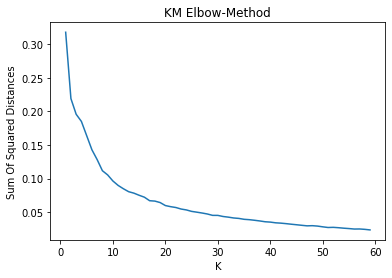

In [7]:
# this gets rid of uneeded attrs (feature selection)
sel        = VarianceThreshold(threshold=(.8*(1-.8)))
featSelect = sel.fit_transform(countryInfo)

# Using minmaxscaler to make values inbetween 0 and 1
mms        = MinMaxScaler(feature_range=(0,1))
mms        = mms.fit(featSelect)
scaledData = mms.transform(featSelect)

# This is getting the data needed to use the elbow method to decide the number of clusters
Sum_of_squared_distances = []
K                        = [i for i in range(1,60)]
distortions              = []
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaledData)
    Sum_of_squared_distances.append(int(km.inertia_))
    distortions.append(sum(np.min(cdist(scaledData, km.cluster_centers_, 'euclidean'), axis=1)) / scaledData.shape[0])
plt.plot(K,distortions)
plt.xlabel('K')
plt.ylabel('Sum Of Squared Distances')
plt.title('KM Elbow-Method')
plt.show

Group 0: ['Iraq', 'Algeria', 'Azerbaijan', 'Ecuador', 'Indonesia', 'Morocco', 'Tunisia', 'South Africa', 'Bhutan', 'Paraguay', 'Mongolia', 'Panama', 'Kazakhstan', 'Jamaica', 'Honduras', 'Bolivia', 'Suriname', 'Uzbekistan', 'Equatorial Guinea', 'Fiji', 'El Salvador', 'Nicaragua', 'Haiti', 'Syria', 'Cabo Verde', 'Botswana']
Group 1: ['Philippines', 'Egypt', 'Nigeria', 'Senegal', 'Togo', 'Cameroon', 'Guinea', 'Guatemala', 'Ghana', 'Mauritania', 'Namibia', 'Central African Republic', 'Tanzania', 'Benin', 'Mayotte', 'Liberia', 'Somalia', 'Zambia', 'Gambia', 'Belize', 'Madagascar', 'Zimbabwe', 'Eritrea', 'Angola', 'Mozambique', 'Guinea-Bissau', 'Mali', 'Sierra Leone', 'Yemen']
Group 2: ['China', 'Thailand', 'Italy', 'Austria', 'Croatia', 'North Macedonia', 'Romania', 'Georgia', 'Estonia', 'Ireland', 'Armenia', 'Portugal', 'Latvia', 'Ukraine', 'Poland', 'Slovenia', 'Bosnia and Herzegovina', 'Serbia', 'Slovakia', 'Moldova', 'Cyprus', 'Albania', 'Aruba', 'Seychelles', 'Trinidad and Tobago', 'Mo

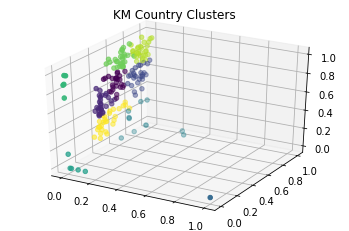

In [12]:
# As you can see in the graph above, ~10 clusters is the elbow
# So now I will create the 3 clusters
km = KMeans(n_clusters = 10)
km = km.fit(scaledData)
labels = km.labels_
clust = dict()
for i in range(len(labels)):
    if(labels[i] not in clust.keys()):
        clust[labels[i]] = [countries[i]]
    else:
        clust[labels[i]].append(countries[i])
        
# graphing the km clusters with their centroids, the different colors demonstrait cluster
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(scaledData[:, 0],scaledData[:, 1],scaledData[:, 2], c=labels,marker='o', cmap = 'viridis')
plt.title('KM Country Clusters')

for group in sorted(list(clust.keys())):
    print("Group "+str(group)+":",clust[group])

<function matplotlib.pyplot.show(*args, **kw)>

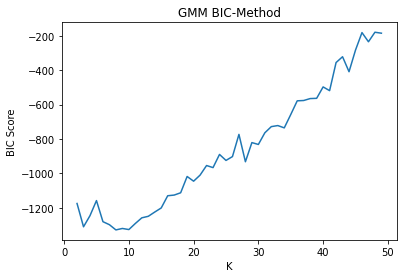

In [13]:
# Finding the best K using the BIC Method
K      = [i for i in range(2,50)]
bic    = []
things = []
for k in K:
    gmm = GaussianMixture(n_components = k,covariance_type='full')
    gmm = gmm.fit(X=scaledData)
    bic = gmm.bic(X=scaledData)
    things.append(bic)
plt.plot(K,things)
plt.xlabel('K')
plt.ylabel('BIC Score')
plt.title('GMM BIC-Method')
plt.show

Group 0: ['Hong Kong', 'Taiwan', 'Singapore', 'Lebanon', 'Bahrain', 'Kuwait', 'Malta', 'Maldives', 'Bangladesh', 'Channel Islands', 'Guadeloupe', 'Aruba', 'Puerto Rico', 'Mayotte', 'Barbados', 'Mauritius']
Group 1: ['South Korea', 'Thailand', 'Japan', 'France', 'Germany', 'Spain', 'Italy', 'Belgium', 'Austria', 'Croatia', 'Switzerland', 'North Macedonia', 'Romania', 'Denmark', 'Netherlands', 'Estonia', 'Lithuania', 'Luxembourg', 'Portugal', 'Latvia', 'Ukraine', 'Hungary', 'Poland', 'Slovenia', 'Bosnia and Herzegovina', 'Serbia', 'Slovakia', 'Martinique', 'Moldova', 'Bulgaria', 'United Kingdom', 'Cuba']
Group 2: ['China', 'US', 'Malaysia', 'Mexico', 'Brazil', 'Colombia', 'Australia', 'Canada', 'Finland', 'United Arab Emirates', 'Sweden', 'Russia', 'Iran', 'Israel', 'Iraq', 'Oman', 'Algeria', 'Greece', 'Norway', 'Georgia', 'San Marino', 'New Zealand', 'Belarus', 'Iceland', 'Ireland', 'Qatar', 'Azerbaijan', 'Ecuador', 'Armenia', 'Dominican Republic', 'Andorra', 'Saudi Arabia', 'Morocco', 

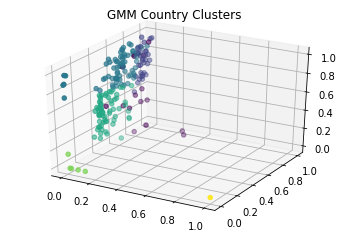

In [14]:
# as you can see the lowest is at ~8 clusters
gmm       = GaussianMixture(n_components = 6)
clusters  = gmm.fit_predict(X = scaledData)
gmm_clust = dict()
for i in range(len(clusters)):
    if(clusters[i] not in gmm_clust.keys()):
        gmm_clust[clusters[i]] = [countries[i]]
    else:
        gmm_clust[clusters[i]].append(countries[i])
        
# graphing the km clusters with their centroids, the different colors demonstrait cluster
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(scaledData[:, 0],scaledData[:, 1],scaledData[:, 2], c=clusters,marker='o', cmap = 'viridis')
plt.title('GMM Country Clusters')

for group in sorted(list(gmm_clust.keys())):
    print("Group "+str(group)+":",gmm_clust[group])

In [15]:
# GMM had 5 clusters created, and KM had 4 clusters created
kmClusters  = clust
gmmClusters = gmm_clust


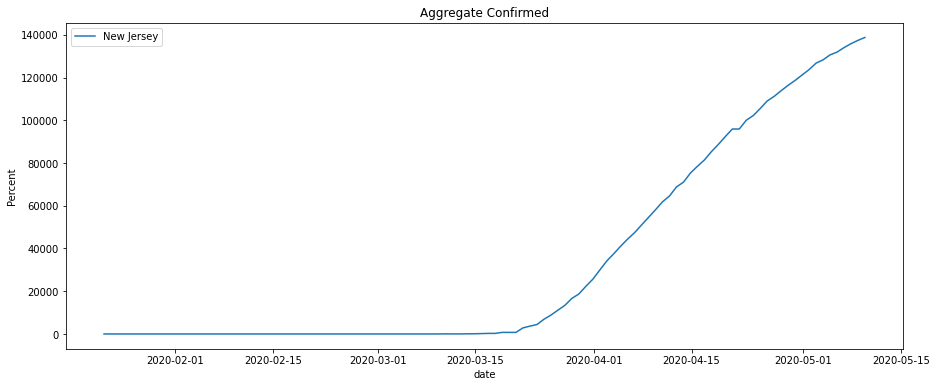

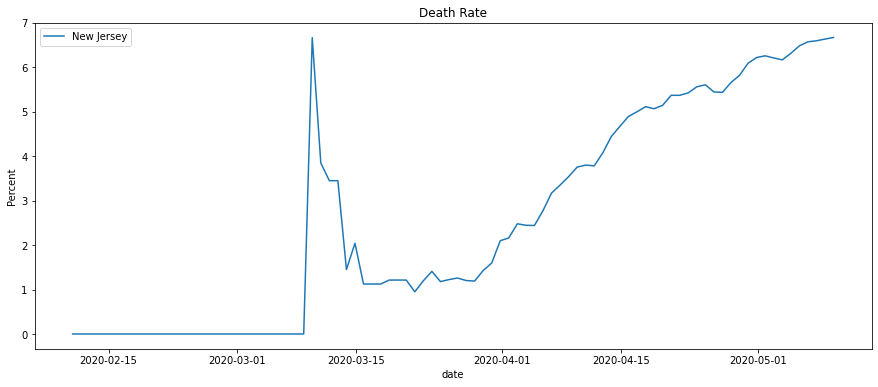

In [32]:
graph   = 'agg_confirmed'
title   = {'pct_deaths':'Death Rate','pct_confirmed':'Percentage of Population Confirmed Cases','agg_confirmed':'Aggregate Confirmed'}

# states
for_PDF = ['New Jersey'] 

# countries
# for_PDF = ['Italy']

plt.figure(num = 1,  figsize=(15,6))
# for c in kmClusters[4][0:10]:
for c in for_PDF:
#     states
    points = [i for i in province_state[c][graph][0:len(province_state[c]['dates'])]]
    dates  = [dt.fromtimestamp(i) for i in distinctDates[0:len(province_state[c]['dates'])]]
#     countries
#     points = [i for i in country[c][graph][0:len(country[c]['dates'])]]
#     dates  = [dt.fromtimestamp(i) for i in distinctDates[0:len(country[c]['dates'])]]
    plt.plot(dates,points,label=c)
plt.xlabel('date')
plt.ylabel('Percent')
plt.title(title[graph])
plt.legend()

graph2 = 'pct_deaths'
title = {'pct_deaths':'Death Rate','pct_confirmed':'Percentage of Population Confirmed Cases'}

plt.figure(num = 2, figsize=(15,6))
# for c in kmClusters[4][0:10]:
for c in for_PDF:
#     states
    points = [i*100 for i in province_state[c][graph2][20:len(province_state[c]['dates'])]]
    dates  = [dt.fromtimestamp(i) for i in distinctDates[20:len(province_state[c]['dates'])]]
#     countries
#     points = [i*100 for i in country[c][graph2][0:len(country[c]['dates'])]]
#     dates  = [dt.fromtimestamp(i) for i in distinctDates[0:len(country[c]['dates'])]]
    plt.plot(dates,points,label=c)
plt.xlabel('date')
plt.ylabel('Percent')
plt.title(title[graph2])
plt.legend()

In [17]:
# The cells below cluster by State (most seemingly accurate is the GMM)

In [18]:
state_data = pd.read_csv('input/statesData.csv')
state_data = state_data.drop_duplicates()

In [19]:
# dataframe creation for data clustering, kindof redundant b/c I have this data already together. but this empty data handles so whatever
stHeads     = ['State','Pop_Density','Pop','LandArea']
sClusterData = []

for i,j in state_data.iterrows():
    sClusterData.append([j['State'],j['Density'],j['Pop'],j['LandArea']])

stateInfo = pd.DataFrame(data=sClusterData,columns = stHeads)
states = stateInfo['State']
stateInfo.drop('State',axis=1,inplace=True)

<function matplotlib.pyplot.show(*args, **kw)>

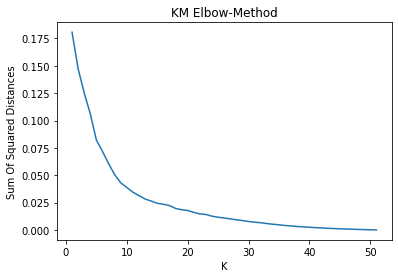

In [20]:
#  this gets rid of uneeded attrs (feature selection)
sel        = VarianceThreshold(threshold=(.8*(1-.8)))
featSelect = sel.fit_transform(stateInfo)
# Using minmaxscaler to make values inbetween 0 and 1
mms        = MinMaxScaler(feature_range=(0,1))
mms        = mms.fit(featSelect)
scaledData = mms.transform(featSelect)

# This is getting the data needed to use the elbow method to decide the number of clusters
Sum_of_squared_distances = []
K                        = [i for i in range(1,52)]
distortions              = []
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaledData)
    Sum_of_squared_distances.append(int(km.inertia_))
    distortions.append(sum(np.min(cdist(scaledData, km.cluster_centers_, 'euclidean'), axis=1)) / scaledData.shape[0])
plt.plot(K,distortions)
plt.xlabel('K')
plt.ylabel('Sum Of Squared Distances')
plt.title('KM Elbow-Method')
plt.show

Group 0: ['Arizona', 'Colorado', 'Oregon', 'Utah', 'Kansas', 'Nevada', 'Nebraska', 'Idaho', 'New Mexico', 'South Dakota', 'North Dakota', 'Montana', 'Wyoming']
Group 1: ['California', 'Texas']
Group 2: ['District of Columbia']
Group 3: ['Massachusetts', 'Maryland', 'Indiana', 'South Carolina', 'Tennessee', 'Washington', 'Kentucky', 'Wisconsin', 'Louisiana', 'Alabama', 'Missouri', 'Minnesota', 'Mississippi', 'Arkansas', 'Oklahoma', 'Iowa']
Group 4: ['Alaska']
Group 5: ['New York', 'Florida']
Group 6: ['New Jersey', 'Ohio', 'Pennsylvania', 'Illinois', 'Virginia', 'North Carolina', 'Georgia', 'Michigan']
Group 7: ['Rhode Island', 'Connecticut', 'Delaware', 'Hawaii', 'New Hampshire', 'West Virginia', 'Vermont', 'Maine']


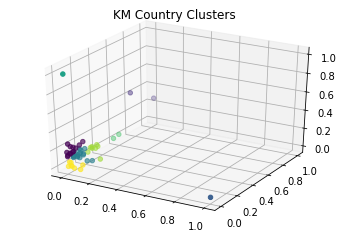

In [188]:
# As you can see in the graph above, ~10 clusters is the elbow
# So now I will create the 3 clusters
km = KMeans(n_clusters = 8)
km = km.fit(scaledData)
labels = km.labels_
sClust = dict()
for i in range(len(labels)):
    if(labels[i] not in sClust.keys()):
        sClust[labels[i]] = [states[i]]
    else:
        sClust[labels[i]].append(states[i])
        
# graphing the km clusters with their centroids, the different colors demonstrait cluster
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(scaledData[:, 0],scaledData[:, 1],scaledData[:, 2], c=labels,marker='o', cmap = 'viridis')
plt.title('KM Country Clusters')

for group in sorted(list(sClust.keys())):
    print("Group "+str(group)+":",sClust[group])

<function matplotlib.pyplot.show(*args, **kw)>

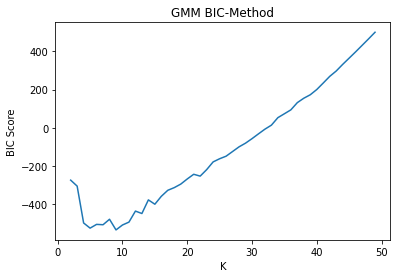

In [182]:
# Finding the best K using the BIC Method
K      = [i for i in range(2,50)]
bic    = []
things = []
for k in K:
    gmm = GaussianMixture(n_components = k,covariance_type='full')
    gmm = gmm.fit(X=scaledData)
    bic = gmm.bic(X=scaledData)
    things.append(bic)
plt.plot(K,things)
plt.xlabel('K')
plt.ylabel('BIC Score')
plt.title('GMM BIC-Method')
plt.show

Group 0: ['Rhode Island', 'Connecticut', 'Delaware', 'Hawaii', 'New Hampshire', 'Vermont']
Group 1: ['New York', 'Florida', 'California', 'Texas']
Group 2: ['Alaska']
Group 3: ['District of Columbia']
Group 4: ['New Jersey', 'Massachusetts', 'Maryland', 'Ohio', 'Pennsylvania', 'Illinois', 'Virginia', 'North Carolina', 'Indiana', 'Georgia', 'Michigan', 'South Carolina', 'Tennessee']
Group 5: ['Washington', 'Kentucky', 'Wisconsin', 'Louisiana', 'Alabama', 'Missouri', 'West Virginia', 'Minnesota', 'Arizona', 'Mississippi', 'Arkansas', 'Oklahoma', 'Iowa', 'Colorado', 'Oregon', 'Maine', 'Utah', 'Kansas', 'Nevada', 'Nebraska', 'Idaho', 'New Mexico', 'South Dakota', 'North Dakota', 'Montana', 'Wyoming']


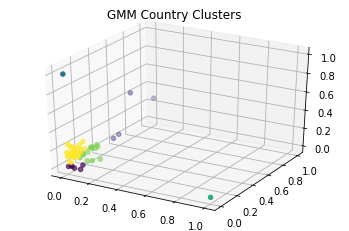

In [186]:
# as you can see the lowest is at ~8 clusters
gmm       = GaussianMixture(n_components = 6
                           )
clusters  = gmm.fit_predict(X = scaledData)
gmm_clust = dict()
for i in range(len(clusters)):
    if(clusters[i] not in gmm_clust.keys()):
        gmm_clust[clusters[i]] = [states[i]]
    else:
        gmm_clust[clusters[i]].append(states[i])
        
# graphing the km clusters with their centroids, the different colors demonstrait cluster
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(scaledData[:, 0],scaledData[:, 1],scaledData[:, 2], c=clusters,marker='o', cmap = 'viridis')
plt.title('GMM Country Clusters')

for group in sorted(list(gmm_clust.keys())):
    print("Group "+str(group)+":",gmm_clust[group])

KeyError: 'timestamp'